In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch  
from scipy.ndimage import gaussian_filter1d

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 6,
    'xtick.labelsize': 6,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [4]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [5]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [6]:
SAVE_DIR_FIG4 = Path(SAVE_DIR) / "figure4"
SAVE_DIR_FIG4.mkdir(parents=True, exist_ok=True)

In [7]:
def save_figure(fig, save_dir, filename, dpi=300, bbox_inches='tight'):
    # Remove any existing file extension from the filename
    base_filename = Path(filename).stem
    
    # Save both PNG and SVG versions
    fig.savefig(Path(save_dir) / f'{base_filename}.png', dpi=dpi, bbox_inches=bbox_inches)
    fig.savefig(Path(save_dir) / f'{base_filename}.svg', dpi=dpi, bbox_inches=bbox_inches)
    plt.close(fig)

## P1-1 - primary brain state time series

In [6]:
# Load the saved results
with open(OUTPUT_DIR / "09_group_HMM_comparison" / "comparisons.pkl", 'rb') as f:
    comp_results = pickle.load(f)

In [26]:
def plot_temporal_dynamics(results, pairs='state_pair_0_0'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5), sharex=True)
    profile = results['temporal_dynamics'][pairs]['temporal_profile']
    

    # Plot affair profile
    ax.plot(profile['affair_profile'],
            color=COLORS['affair'],
        #     label='Affair',
            linewidth=1)
    
    # Plot paranoia profile
    ax.plot(profile['paranoia_profile'],
            color=COLORS['paranoia'],
        #     label='Paranoia ',
            linewidth=1)
    
    ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlabel('Time (TRs)')
    
    # ax.set_ylabel('State Probability')
    # ax.legend()
    
    # Set y-axis limits
    ax.set_ylim(0, 1)
    
    # Make x-axis start from 0
    max_length = max(len(profile['affair_profile']), len(profile['paranoia_profile']))
    ax.set_xlim(0, max_length - 1)

    plt.tight_layout()
    plt.show()
    save_figure(fig, SAVE_DIR_FIG4, f'group_temporal_dynamics_{pairs}')
    
    plt.close()

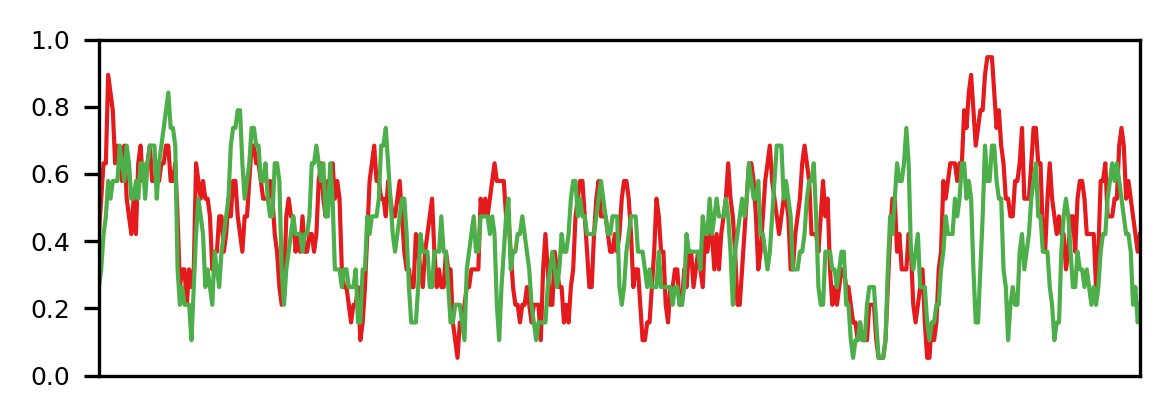

In [27]:
plot_temporal_dynamics(comp_results)

## P1-2 - content feature

In [19]:
def create_tr_raster_plot(annotations_file: str, save_path: str, label: bool = False) -> plt.Figure:
    """Create raster plot of story features at TR level."""
    # Read data
    df = pd.read_csv(annotations_file)
    
    # Filter to only include features that exist in the dataframe
    binary_features = ['is_dialog', 'arthur_speaking', 'lee_speaking', 
                       'girl_speaking', 'lee_girl_together', 'has_verb', 
                       'has_noun', 'has_adj', 'has_adv']
    binary_features = sorted(binary_features)
 
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    
    # Colors for binary features (use only as many as needed)
    colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', 
             '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148']
    
    # Plot binary features
    for idx, (feature, color) in enumerate(zip(binary_features, colors)):
        mask = df[feature].astype(bool)
        if mask.any():
            ax.vlines(df.loc[mask, 'adjusted_onset_TR'], 
                      idx - 0.2, idx + 0.2,
                      color=color, linewidth=1)
    
    # Customize binary features plot
    ax.set_xticks([])
    if label:
        # ax.set_yticks([])
        ax.set_yticks(range(len(binary_features)))
        ax.set_yticklabels([f.replace('_', ' ').title() for f in binary_features])
        save_path = save_path + '_label'
    else:
        ax.set_yticks([])
        save_path = save_path + '_nolabel'
    
    ax.set_xlim(0, df['adjusted_onset_TR'].max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.set_xlabel('Time (TR)')
    # ax.set_title('Story Features', pad=10)
    
    plt.tight_layout()
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.png', dpi=300, bbox_inches='tight')
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [15]:
data_dir = os.path.join(scratch_dir, 'data', 'stimuli')
content_file = Path(data_dir) / "10_story_annotations_TR.csv"

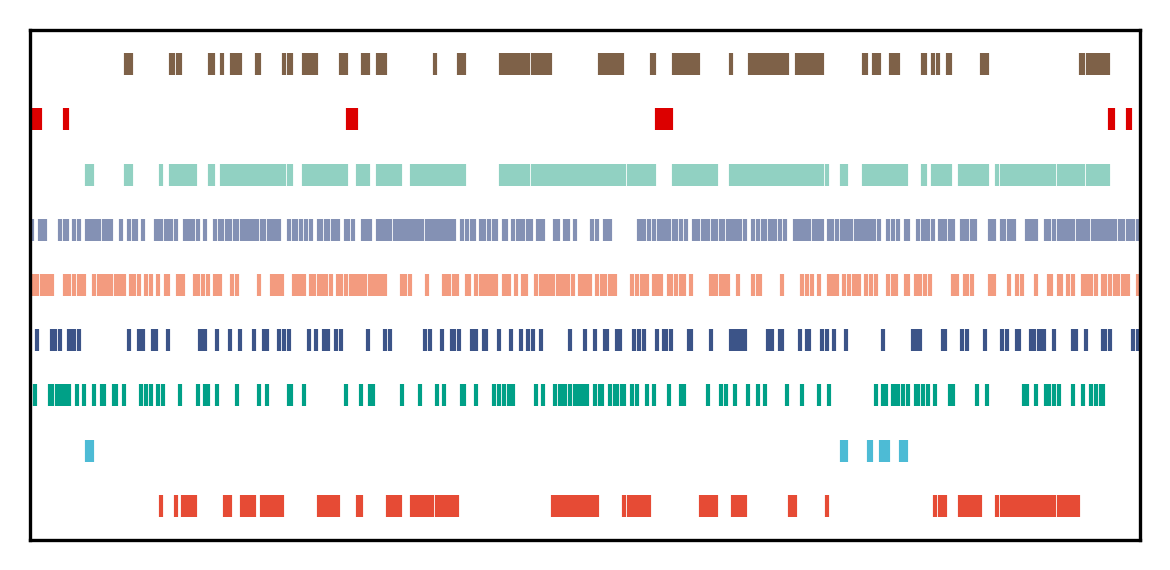

In [21]:
create_tr_raster_plot(content_file, 'content_tr_raster_plot', label=False)

## P1-3 - behavior data

In [28]:
affair_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_affair.pkl'
paranoia_beh_file = Path(OUTPUT_DIR) / 'behav_results' / 'individual_response_evidence_paranoia.pkl'
affair_beh_data = pickle.load(open(affair_beh_file, 'rb'))
paranoia_beh_data = pickle.load(open(paranoia_beh_file, 'rb'))

In [29]:
def safe_eval_response(response, offset=14, n_timepoints=451):
    """
    Safely handle response data with time shift.
    
    Parameters:
    -----------
    response : array-like
        Response data
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep
    """
    if isinstance(response, np.ndarray):
        data = response[offset:offset+n_timepoints]
    elif isinstance(response, list):
        data = np.array(response[offset:offset+n_timepoints])
    else:
        raise ValueError(f"Unexpected response type: {type(response)}")
    
    return data

In [30]:
def plot_behavioral_responses(affair_data, paranoia_data, offset=14, n_timepoints=451):
    """
    Create visualization of behavioral responses with both groups in a single plot,
    including individual participant responses as jittered dots.
    
    Parameters:
    -----------
    affair_data : pd.DataFrame
        DataFrame containing affair group responses
    paranoia_data : pd.DataFrame
        DataFrame containing paranoia group responses
    offset : int
        Number of TRs to discard from start
    n_timepoints : int
        Total number of timepoints to keep after offset
    """
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    
    # Set up time points (starting at 0 after offset)
    time_points = np.arange(n_timepoints)
    
    # Process affair group
    affair_responses = []
    
    # Define jitter range - use most of the plot height
    # Leave some space at top and bottom for the lines to be visible
    jitter_range = 0.4  # This will spread dots across most of the 0-0.5 y-axis range
    
    for idx, row in enumerate(affair_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            affair_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['affair_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing affair participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for affair group
    if affair_responses:
        affair_responses = np.array(affair_responses)
        affair_avg = affair_responses.mean(axis=0)
        affair_avg_smooth = gaussian_filter1d(affair_avg, sigma=2)
        ax.plot(time_points, affair_avg_smooth, color=COLORS['affair'], linewidth=1.5, label='Affair')
    
    # Process paranoia group
    paranoia_responses = []
    
    for idx, row in enumerate(paranoia_data.iterrows()):
        try:
            # Get response data with offset
            response = np.array(row[1]['binary_response'])[offset:offset+n_timepoints]
            paranoia_responses.append(response)
            
            # Plot individual responses as dots with jitter
            response_times = np.where(response == 1)[0]
            # Add random jitter to y-position
            jitter = np.random.uniform(0.05, jitter_range, size=len(response_times))
            ax.scatter(response_times, 
                      jitter,  # Spread across the plot
                      color=COLORS['paranoia_light'], alpha=0.2, s=1)
            
        except Exception as e:
            print(f"Error processing paranoia participant {idx}: {str(e)}")
            continue
    
    # Calculate and plot average for paranoia group
    if paranoia_responses:
        paranoia_responses = np.array(paranoia_responses)
        paranoia_avg = paranoia_responses.mean(axis=0)
        paranoia_avg_smooth = gaussian_filter1d(paranoia_avg, sigma=2)
        ax.plot(time_points, paranoia_avg_smooth, color=COLORS['paranoia'], linewidth=1.5, label='Paranoia')
    
    # Customize plot
    ax.set_ylim(0, 0.4)  # Adjust as needed
    ax.set_xlim(0, n_timepoints-1)  # Set x-axis to match data length
    
    # Add labels
    # ax.set_ylabel('Response Probability')
    # ax.set_xlabel('Time (TRs)')
    
    # Add x-axis ticks every 50 TRs
    tick_interval = 50
    ax.set_xticks(np.arange(0, n_timepoints, tick_interval))
    
    # Add legend
    # ax.legend(loc='upper right')
    
    # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    # Save figure
    save_figure(fig, SAVE_DIR_FIG4, 'behavioral_responses_combined')
    plt.close()

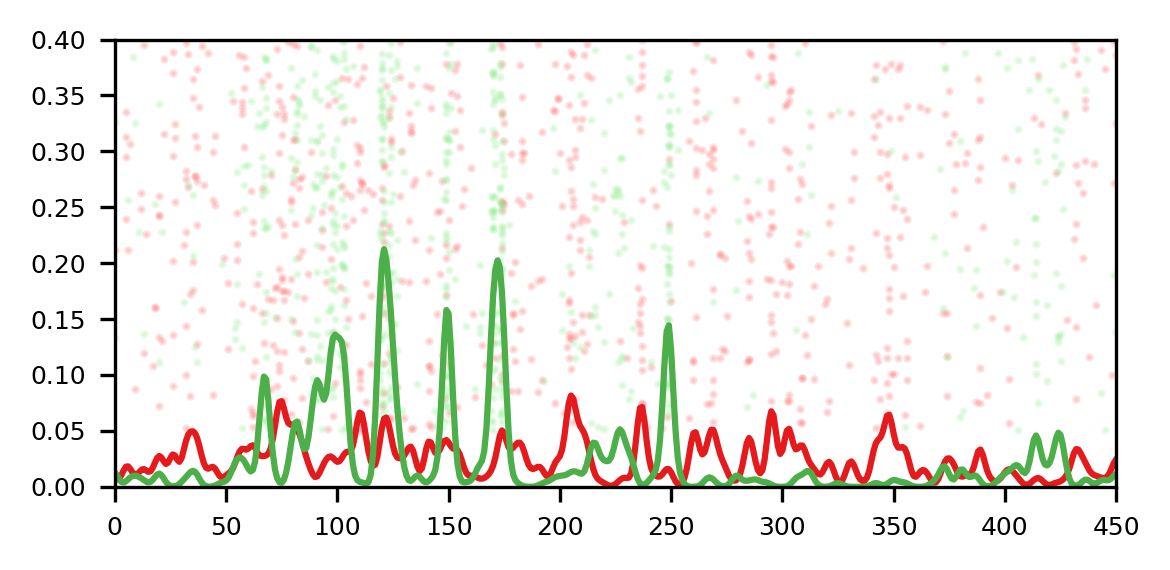

In [31]:
plot_behavioral_responses(affair_beh_data, paranoia_beh_data)

## P2 - brain-content analysis

In [19]:
def plot_brain_state_effects_v2(main_analysis, save_path=None, figsize=(4, 3), label=False):
    """Create figure showing content feature effects for each brain state group"""
    # Convert numpy array to dictionary if needed
    if isinstance(main_analysis, np.ndarray):
        results_dict = main_analysis.item()
    else:
        results_dict = main_analysis
    
    # Create figure with two subplots (one for each group)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Features to plot
    plot_features = ['has_adj', 'has_adv', 'has_noun', 'has_verb', 'arthur_speaking', 
                     'girl_speaking', 'lee_speaking', 'arthur_adj', 'lee_girl_together', 
                     'lee_girl_verb']

    # Data containers for each group
    affair_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    paranoia_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    # Populate data
    for feature in plot_features:
        if feature in results_dict['feature_results']:
            feature_data = results_dict['feature_results'][feature]
            
            # Check for group_specific_effects
            if 'group_specific_effects' not in feature_data or 'main' not in feature_data['group_specific_effects']:
                print(f"Warning: group_specific_effects/main not found for feature '{feature}'")
                continue
            
            group_specific = feature_data['group_specific_effects']['main']
            
            # Add affair group data
            affair_group_data = group_specific.get('affair_group', {})
            if affair_group_data:
                affair_data['feature'].append(feature)
                affair_data['effect'].append(affair_group_data.get('odds_ratio', None))
                affair_data['ci_lower'].append(affair_group_data.get('lower', None))
                affair_data['ci_upper'].append(affair_group_data.get('upper', None))
                affair_data['probability'].append(affair_group_data.get('prob_positive', None))
            
            # Add paranoia group data
            paranoia_group_data = group_specific.get('paranoia_group', {})
            if paranoia_group_data:
                paranoia_data['feature'].append(feature)
                paranoia_data['effect'].append(paranoia_group_data.get('odds_ratio', None))
                paranoia_data['ci_lower'].append(paranoia_group_data.get('lower', None))
                paranoia_data['ci_upper'].append(paranoia_group_data.get('upper', None))
                paranoia_data['probability'].append(paranoia_group_data.get('prob_positive', None))
    
    # Check if we have data to plot
    if not affair_data['feature'] or not paranoia_data['feature']:
        print("Error: No valid data found for plotting.")
        return None
    
    # Define group colors
    # Define group colors
    affair_color = COLORS['affair']
    paranoia_color = COLORS['paranoia']
    
    # Helper function for color adjustment
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = plt.cm.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    # Function to plot one group
    def plot_group(ax, df, title, color, is_bottom=False, show_label=False):
        # Create color variants for probability levels
        color_high = color
        color_med = adjust_color_alpha(color, 0.7)
        color_low = adjust_color_alpha(color, 0.4)
        gray_color = '#777777'
        
        # Determine color based on posterior probability AND CI crossing zero
        colors = []
        for _, row in df.iterrows():
            # Check if CI crosses zero
            ci_crosses_zero = (row['ci_lower'] < 0 and row['ci_upper'] > 0)
            
            # Get the posterior probability
            prob = row['probability']
            
            # Assign color based on probability and CI
            if not ci_crosses_zero:
                if prob > 0.999:
                    colors.append(color_high)
                elif prob > 0.99:
                    colors.append(color_med)  
                elif prob > 0.95:
                    colors.append(color_low)
                else:
                    colors.append(gray_color)
            else:
                colors.append(gray_color)
        # Calculate x-positions
        x_pos = np.arange(len(df))
        
        # Plot reference line at odds ratio = 1 (no effect)
        ax.axhline(y=1, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
        # Plot data points and intervals
        for i, (_, row) in enumerate(df.iterrows()):
            # Plot CI line
            ax.vlines(x=x_pos[i], ymin=row['ci_lower'], ymax=row['ci_upper'], 
                     color=colors[i], alpha=0.6, linewidth=1)
            
            # Plot point
            ax.scatter(x_pos[i], row['effect'], color=colors[i], s=5, zorder=3)
        
        # Set y-axis to log scale and label
        # ax.set_yscale('log')
        ax.set_ylabel("Odds Ratio")

        # Add x-axis labels
        if is_bottom and show_label:
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f.replace('_', ' ').title() for f in df['feature']], 
                              rotation=90, ha='right')
        elif not show_label:
            ax.set_xticks([])
            ax.set_xticklabels([])

        # ax.set_title(title)
        
        # Add grid
        ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # Calculate global min and max for consistent y-axis scaling
    min_effect = min(min(df_affair['effect']), min(df_paranoia['effect']))
    max_effect = max(max(df_affair['effect']), max(df_paranoia['effect']))
    
    min_ci = min(min(df_affair['ci_lower']), min(df_paranoia['ci_lower']))
    max_ci = max(max(df_affair['ci_upper']), max(df_paranoia['ci_upper']))
    
    global_min = min(min_effect, min_ci)
    global_max = max(max_effect, max_ci)
    
    # Add padding factor for log scale (multiplicative)
    padding_factor = 1.2
    global_y_min = global_min / padding_factor
    global_y_max = global_max * padding_factor
    
    # Plot both groups
    plot_group(ax1, df_affair, "", affair_color, is_bottom=False, show_label=False)
    plot_group(ax2, df_paranoia, "", paranoia_color, is_bottom=True, show_label=label)
    
    # Set the same y-axis limits for both plots
    ax1.set_ylim(global_y_min, global_y_max)
    ax2.set_ylim(global_y_min, global_y_max)
    
    # Set x-axis limits
    ax1.set_xlim(-0.5, len(df_affair) - 0.5)
    ax2.set_xlim(-0.5, len(df_paranoia) - 0.5)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    
    # Save figure if requested
    if save_path:
        suffix = "_label" if label else "_nolabel"
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}{suffix}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}{suffix}.svg', dpi=300, bbox_inches='tight')
    
    return fig

In [16]:
def get_brain_content_data(state_affair, state_paranoia):
    # Use Path.glob() method instead of glob module
    # pattern = f'hierarchical_analysis_results_*.npz'
    # search_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}'
    # search_path = Path(OUTPUT_DIR) / '11_brain_content_analysis_v2' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}'
    brain_content_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}_coding_deviation'/'hierarchical_analysis_results.npz'
    brain_content_data = np.load(brain_content_path, allow_pickle=True)
    meta_data = brain_content_data['metadata']
    main_analysis = brain_content_data['main_analysis']
    cross_validation = brain_content_data['cross_validation']
    return meta_data, main_analysis, cross_validation

In [17]:
state_map = {"affair_to_paranoia": {0:1, 1:2, 2:0}, "paranoia_to_affair": {1:0, 2:1, 0:2}}
state_affair = 0
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a0p1 , main_analysis_a0p1, cross_validation_a0p1 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 1
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a1p2, main_analysis_a1p2, cross_validation_a1p2 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 2
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a2p0, main_analysis_a2p0, cross_validation_a2p0 = get_brain_content_data(state_affair, state_paranoia)

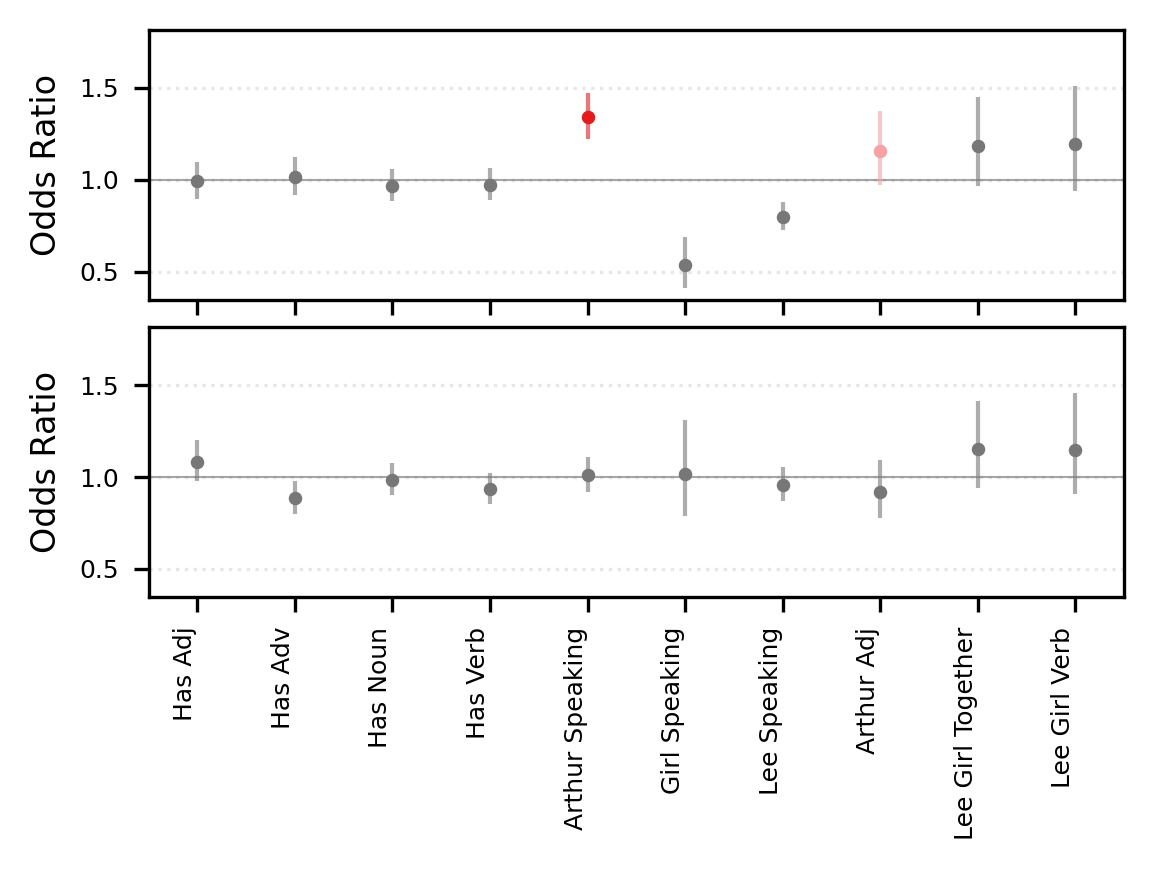

In [20]:
plot_brain_state_effects_v2(main_analysis_a0p1, save_path=None, figsize=(4, 3), label=True)

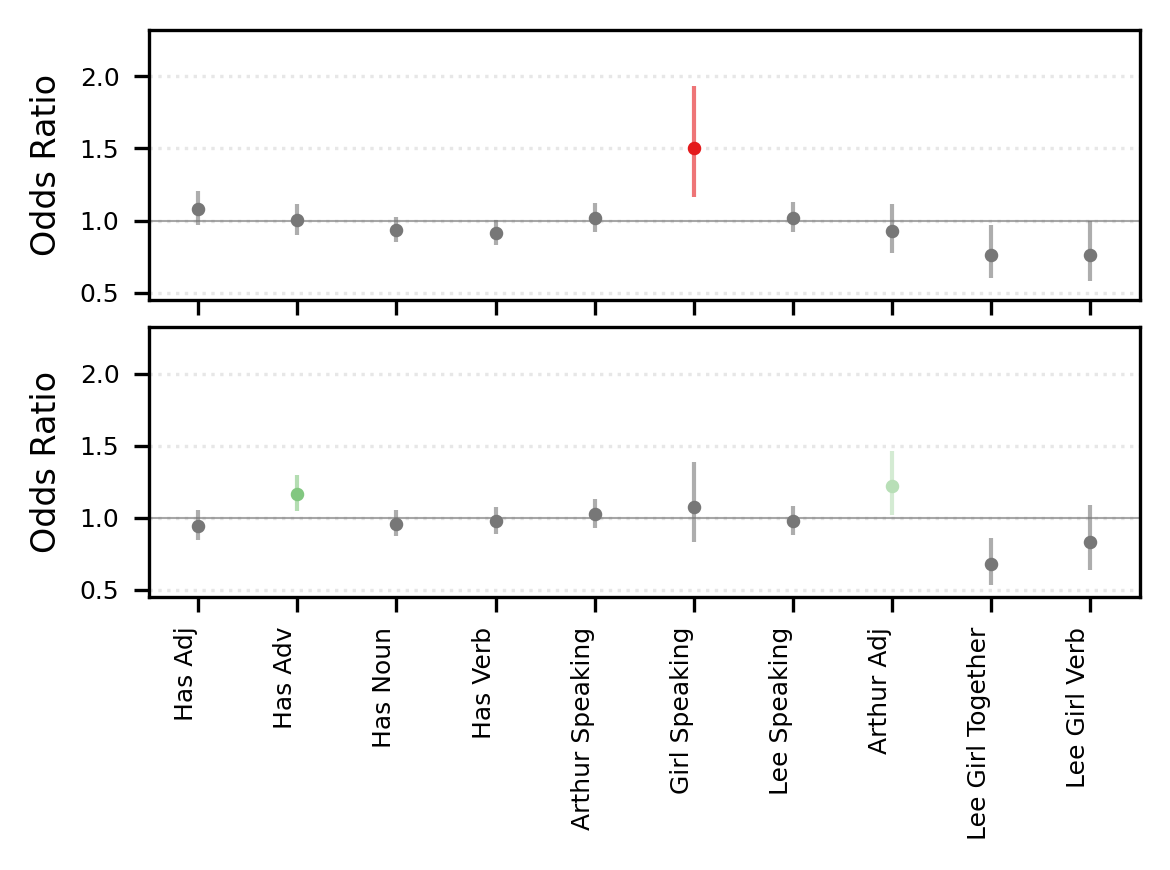

In [21]:
plot_brain_state_effects_v2(main_analysis_a1p2, save_path=None, figsize=(4, 3), label=True)

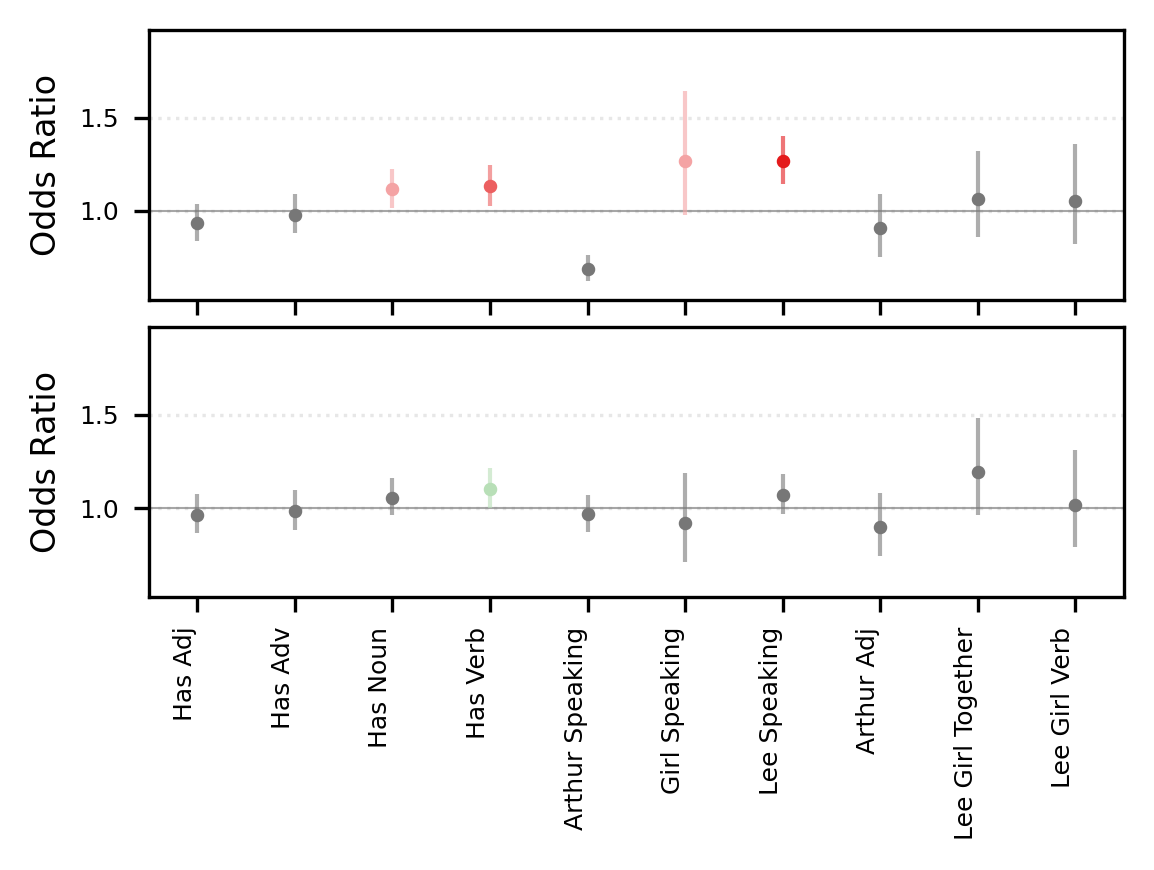

In [22]:
plot_brain_state_effects_v2(main_analysis_a2p0, save_path=None, figsize=(4, 3), label=True)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_glmm_effects(data_dict, output_file=None, 
                     plot_title="Bayesian GLMM Effects", fig_size=(15, 10),
                     credible_intervals=True, prob_markers=True,
                     include_rope=False, rope_width=0.1):
    """
    Plot the effects from Bayesian GLMM results with proper Bayesian terminology.
    
    Parameters:
    -----------
    data_dict : dict or numpy.ndarray
        Dictionary or numpy array containing the Bayesian GLMM results data
    output_file : str, optional
        Path to save the plot, if None, plot is displayed
    plot_title : str, default="Bayesian GLMM Effects"
        Title for the overall plot
    fig_size : tuple, default=(15, 10)
        Figure size (width, height) in inches
    credible_intervals : bool, default=True
        Whether to include 95% credible intervals in the plot
    prob_markers : bool, default=True
        Whether to include posterior probability markers in the plot
    include_rope : bool, default=False
        Whether to include a Region of Practical Equivalence (ROPE) in the plot
    rope_width : float, default=0.1
        Width of the ROPE if included
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Handle numpy array case by converting to dictionary
    if isinstance(data_dict, np.ndarray):
        if hasattr(data_dict, 'item'):
            # Convert to dictionary using item() method
            data_dict = data_dict.item()
        else:
            # Try to convert manually
            data_dict = dict(data_dict.tolist()) if hasattr(data_dict, 'tolist') else data_dict
    
    # Extract feature results - handle different dictionary structures
    if isinstance(data_dict, dict):
        feature_results = data_dict.get('feature_results', {})
    else:
        raise ValueError("Could not convert input data to a usable dictionary format")
    
    # Create dataframes for plotting
    coef_data = []
    for feature_name, feature_data in feature_results.items():
        # Get coefficients
        coeffs = feature_data.get('coefficients', {})
        # Get posterior standard deviations for credible intervals
        post_sds = feature_data.get('posterior_sds', {})
        # Get posterior probabilities
        post_probs = feature_data.get('posterior_prob', {})
        # Get HDI (highest density interval) if available
        hdi_data = feature_data.get('hdi', {})
        
        # Extract HDI values if available
        feature_hdi_lower = hdi_data.get('feature', {}).get('lower', None)
        feature_hdi_upper = hdi_data.get('feature', {}).get('upper', None)
        group_hdi_lower = hdi_data.get('group', {}).get('lower', None)
        group_hdi_upper = hdi_data.get('group', {}).get('upper', None)
        interaction_hdi_lower = hdi_data.get('interaction', {}).get('lower', None)
        interaction_hdi_upper = hdi_data.get('interaction', {}).get('upper', None)
        
        coef_data.append({
            'feature': feature_name,
            'const': coeffs.get('const', 0),
            'feature_coef': coeffs.get('feature', 0),
            'group_coef': coeffs.get('group', 0),
            'interaction_coef': coeffs.get('interaction', 0),
            'const_sd': post_sds.get('const', 0),
            'feature_sd': post_sds.get('feature', 0),
            'group_sd': post_sds.get('group', 0),
            'interaction_sd': post_sds.get('interaction', 0),
            'const_prob': post_probs.get('const', 0),
            'feature_prob': post_probs.get('feature', 0),
            'group_prob': post_probs.get('group', 0),
            'interaction_prob': post_probs.get('interaction', 0),
            'feature_hdi_lower': feature_hdi_lower,
            'feature_hdi_upper': feature_hdi_upper,
            'group_hdi_lower': group_hdi_lower,
            'group_hdi_upper': group_hdi_upper,
            'interaction_hdi_lower': interaction_hdi_lower,
            'interaction_hdi_upper': interaction_hdi_upper
        })
    
    # Convert to DataFrame
    coef_df = pd.DataFrame(coef_data)
    
    # Extract group names
    group_stats = data_dict.get('group_stats', {})
    occupancy = group_stats.get('occupancy', {})
    if occupancy:
        group_names = list(occupancy.keys())
    else:
        # Fallback to checking if the keys are in the data directly
        if 'affair' in str(data_dict) and 'paranoia' in str(data_dict):
            group_names = ["affair", "paranoia"]
        else:
            group_names = ["Group 1", "Group 2"]
    
    # Create a new figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=fig_size)
    fig.suptitle(plot_title, fontsize=16)
    
    # 1. Plot Main Effects (feature coefficients)
    feature_effects = coef_df.sort_values('feature_coef', ascending=False)
    
    # Create horizontal bar plot
    sns.barplot(
        x='feature_coef', 
        y='feature',
        data=feature_effects,
        palette='coolwarm',
        ax=ax1
    )
    
    # Add credible intervals if requested
    if credible_intervals:
        for i, row in feature_effects.iterrows():
            if row['feature_hdi_lower'] is not None and row['feature_hdi_upper'] is not None:
                # Use HDI if available
                xerr_low = row['feature_coef'] - row['feature_hdi_lower']
                xerr_high = row['feature_hdi_upper'] - row['feature_coef']
                ax1.errorbar(
                    x=row['feature_coef'],
                    y=i,
                    xerr=[[xerr_low], [xerr_high]],  # Asymmetric errors
                    fmt='none',
                    color='black',
                    capsize=3
                )
            else:
                # Fall back to using posterior SD with 95% CI
                ax1.errorbar(
                    x=row['feature_coef'],
                    y=i,
                    xerr=row['feature_sd'] * 1.96,  # 95% CI approximation
                    fmt='none',
                    color='black',
                    capsize=3
                )
    
    # Add posterior probability markers if requested
    if prob_markers:
        for i, row in feature_effects.iterrows():
            # Get directional probability (probability of being positive or negative)
            prob_value = max(row['feature_prob'], 1 - row['feature_prob'])  
            direction = "+" if row['feature_prob'] > 0.5 else "-"
            
            if prob_value > 0.99:
                ax1.text(
                    x=row['feature_coef'] + (0.02 if row['feature_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†††',
                    va='center',
                    ha='left' if row['feature_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.95:
                ax1.text(
                    x=row['feature_coef'] + (0.02 if row['feature_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}††',
                    va='center',
                    ha='left' if row['feature_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.9:
                ax1.text(
                    x=row['feature_coef'] + (0.02 if row['feature_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†',
                    va='center',
                    ha='left' if row['feature_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
    
    # Add ROPE if requested
    if include_rope:
        ax1.axvspan(-rope_width, rope_width, alpha=0.1, color='gray')
    
    # Add reference line at 0
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set titles and labels
    ax1.set_title('Main Effects (Feature Coefficients)', fontsize=14)
    ax1.set_xlabel('Coefficient Value', fontsize=12)
    ax1.set_ylabel('Feature', fontsize=12)
    
    # 2. Plot Group Effects
    group_effects = coef_df.sort_values('group_coef', ascending=False)
    
    # Create horizontal bar plot
    sns.barplot(
        x='group_coef', 
        y='feature',
        data=group_effects,
        palette='viridis',
        ax=ax2
    )
    
    # Add credible intervals if requested
    if credible_intervals:
        for i, row in group_effects.iterrows():
            if row['group_hdi_lower'] is not None and row['group_hdi_upper'] is not None:
                # Use HDI if available
                xerr_low = row['group_coef'] - row['group_hdi_lower']
                xerr_high = row['group_hdi_upper'] - row['group_coef']
                ax2.errorbar(
                    x=row['group_coef'],
                    y=i,
                    xerr=[[xerr_low], [xerr_high]],  # Asymmetric errors
                    fmt='none',
                    color='black',
                    capsize=3
                )
            else:
                # Fall back to using posterior SD with 95% CI
                ax2.errorbar(
                    x=row['group_coef'],
                    y=i,
                    xerr=row['group_sd'] * 1.96,  # 95% CI approximation
                    fmt='none',
                    color='black',
                    capsize=3
                )
    
    # Add posterior probability markers if requested
    if prob_markers:
        for i, row in group_effects.iterrows():
            # Get directional probability (probability of being positive or negative)
            prob_value = max(row['group_prob'], 1 - row['group_prob'])
            direction = "+" if row['group_prob'] > 0.5 else "-"
            
            if prob_value > 0.99:
                ax2.text(
                    x=row['group_coef'] + (0.02 if row['group_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†††',
                    va='center',
                    ha='left' if row['group_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.95:
                ax2.text(
                    x=row['group_coef'] + (0.02 if row['group_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}††',
                    va='center',
                    ha='left' if row['group_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.9:
                ax2.text(
                    x=row['group_coef'] + (0.02 if row['group_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†',
                    va='center',
                    ha='left' if row['group_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
    
    # Add ROPE if requested
    if include_rope:
        ax2.axvspan(-rope_width, rope_width, alpha=0.1, color='gray')
    
    # Add reference line at 0
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set titles and labels
    ax2.set_title(f'Group Effects ({group_names[0]} vs {group_names[1]})', fontsize=14)
    ax2.set_xlabel('Coefficient Value', fontsize=12)
    ax2.set_ylabel('Feature', fontsize=12)
    
    # 3. Plot Interaction Effects
    interaction_effects = coef_df.sort_values('interaction_coef', ascending=False)
    
    # Create horizontal bar plot
    sns.barplot(
        x='interaction_coef', 
        y='feature',
        data=interaction_effects,
        palette='plasma',
        ax=ax3
    )
    
    # Add credible intervals if requested
    if credible_intervals:
        for i, row in interaction_effects.iterrows():
            if row['interaction_hdi_lower'] is not None and row['interaction_hdi_upper'] is not None:
                # Use HDI if available
                xerr_low = row['interaction_coef'] - row['interaction_hdi_lower']
                xerr_high = row['interaction_hdi_upper'] - row['interaction_coef']
                ax3.errorbar(
                    x=row['interaction_coef'],
                    y=i,
                    xerr=[[xerr_low], [xerr_high]],  # Asymmetric errors
                    fmt='none',
                    color='black',
                    capsize=3
                )
            else:
                # Fall back to using posterior SD with 95% CI
                ax3.errorbar(
                    x=row['interaction_coef'],
                    y=i,
                    xerr=row['interaction_sd'] * 1.96,  # 95% CI approximation
                    fmt='none',
                    color='black',
                    capsize=3
                )
    
    # Add posterior probability markers if requested
    if prob_markers:
        for i, row in interaction_effects.iterrows():
            # Get directional probability (probability of being positive or negative)
            prob_value = max(row['interaction_prob'], 1 - row['interaction_prob'])
            direction = "+" if row['interaction_prob'] > 0.5 else "-"
            
            if prob_value > 0.99:
                ax3.text(
                    x=row['interaction_coef'] + (0.02 if row['interaction_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†††',
                    va='center',
                    ha='left' if row['interaction_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.95:
                ax3.text(
                    x=row['interaction_coef'] + (0.02 if row['interaction_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}††',
                    va='center',
                    ha='left' if row['interaction_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
            elif prob_value > 0.9:
                ax3.text(
                    x=row['interaction_coef'] + (0.02 if row['interaction_coef'] >= 0 else -0.02),
                    y=i,
                    s=f'{direction}†',
                    va='center',
                    ha='left' if row['interaction_coef'] >= 0 else 'right',
                    fontweight='bold'
                )
    
    # Add ROPE if requested
    if include_rope:
        ax3.axvspan(-rope_width, rope_width, alpha=0.1, color='gray')
    
    # Add reference line at 0
    ax3.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set titles and labels
    ax3.set_title('Interaction Effects (Feature × Group)', fontsize=14)
    ax3.set_xlabel('Coefficient Value', fontsize=12)
    ax3.set_ylabel('Feature', fontsize=12)
    
    # Add a legend for posterior probability
    if prob_markers:
        # Create a custom legend
        legend_elements = [
            Line2D([0], [0], marker='', color='none', label='Posterior Probability:', 
                  markerfacecolor='none', markersize=0),
            Line2D([0], [0], marker='', color='none', label='† : P > 0.9', 
                  markerfacecolor='none', markersize=0),
            Line2D([0], [0], marker='', color='none', label='†† : P > 0.95', 
                  markerfacecolor='none', markersize=0),
            Line2D([0], [0], marker='', color='none', label='††† : P > 0.99', 
                  markerfacecolor='none', markersize=0),
            Line2D([0], [0], marker='', color='none', label='+ : positive effect', 
                  markerfacecolor='none', markersize=0),
            Line2D([0], [0], marker='', color='none', label='- : negative effect', 
                  markerfacecolor='none', markersize=0)
        ]
        
        if include_rope:
            rope_patch = plt.Rectangle((0, 0), 1, 1, fc="gray", alpha=0.1)
            legend_elements.append((rope_patch, f"ROPE: ±{rope_width}"))
            
        fig.legend(handles=legend_elements, loc='lower center', 
                  bbox_to_anchor=(0.5, 0.01), ncol=3, frameon=False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Save or show the figure
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    return fig

def plot_bayesian_odds_ratios(data_dict, output_file=None, 
                             plot_title="Odds Ratios from Bayesian GLMM", 
                             fig_size=(12, 10),
                             include_rope=False, rope_width=0.1):
    """
    Plot odds ratios from Bayesian GLMM results with proper Bayesian terminology.
    
    Parameters:
    -----------
    data_dict : dict or numpy.ndarray
        Dictionary or numpy array containing the Bayesian GLMM results data
    output_file : str, optional
        Path to save the plot, if None, plot is displayed
    plot_title : str, default="Odds Ratios from Bayesian GLMM"
        Title for the plot
    fig_size : tuple, default=(12, 10)
        Figure size (width, height) in inches
    include_rope : bool, default=False
        Whether to include a Region of Practical Equivalence (ROPE) in the plot
    rope_width : float, default=0.1
        Width of the ROPE if included, applied to odds ratio scale
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    """
    # Handle numpy array case by converting to dictionary
    if isinstance(data_dict, np.ndarray):
        if hasattr(data_dict, 'item'):
            # Convert to dictionary using item() method
            data_dict = data_dict.item()
        else:
            # Try to convert manually
            data_dict = dict(data_dict.tolist()) if hasattr(data_dict, 'tolist') else data_dict
    
    # Extract feature results
    if isinstance(data_dict, dict):
        feature_results = data_dict.get('feature_results', {})
    else:
        raise ValueError("Could not convert input data to a usable dictionary format")
    
    # Create dataframe for odds ratios
    odds_data = []
    for feature_name, feature_data in feature_results.items():
        # Get odds ratios
        odds_ratios = feature_data.get('odds_ratios', {})
        # Get posterior probabilities
        post_probs = feature_data.get('posterior_prob', {})
        
        # Extract group odds ratio
        group_odds = odds_ratios.get('group', {})
        
        if group_odds:
            odds_data.append({
                'feature': feature_name,
                'odds_ratio': group_odds.get('odds_ratio', 1.0),
                'lower_hdi': group_odds.get('lower', 1.0),
                'upper_hdi': group_odds.get('upper', 1.0),
                'prob_positive': post_probs.get('group', 0.5)
            })
    
    # Convert to DataFrame
    odds_df = pd.DataFrame(odds_data)
    
    # Sort by odds ratio
    odds_df = odds_df.sort_values('odds_ratio', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Plot odds ratios as forest plot
    y_positions = np.arange(len(odds_df))
    
    # Plot the odds ratios
    ax.scatter(
        odds_df['odds_ratio'], 
        y_positions, 
        s=100, 
        color='blue', 
        zorder=3
    )
    
    # Add error bars for highest density intervals
    for i, (_, row) in enumerate(odds_df.iterrows()):
        ax.plot(
            [row['lower_hdi'], row['upper_hdi']],
            [i, i],
            color='blue',
            linestyle='-',
            linewidth=2,
            zorder=2
        )
        
        # Add vertical lines at HDI edges
        ax.plot(
            [row['lower_hdi'], row['lower_hdi']],
            [i-0.1, i+0.1],
            color='blue',
            linestyle='-',
            linewidth=2,
            zorder=2
        )
        
        ax.plot(
            [row['upper_hdi'], row['upper_hdi']],
            [i-0.1, i+0.1],
            color='blue',
            linestyle='-',
            linewidth=2,
            zorder=2
        )
        
        # Add posterior probability markers
        prob_value = max(row['prob_positive'], 1 - row['prob_positive'])
        direction = "+" if row['prob_positive'] > 0.5 else "-"
        
        if prob_value > 0.99:
            ax.text(
                x=row['odds_ratio'] * 1.05,
                y=i,
                s=f'{direction}†††',
                va='center',
                fontweight='bold'
            )
        elif prob_value > 0.95:
            ax.text(
                x=row['odds_ratio'] * 1.05,
                y=i,
                s=f'{direction}††',
                va='center',
                fontweight='bold'
            )
        elif prob_value > 0.9:
            ax.text(
                x=row['odds_ratio'] * 1.05,
                y=i,
                s=f'{direction}†',
                va='center',
                fontweight='bold'
            )
    
    # Add a ROPE region if requested
    if include_rope:
        ax.axvspan(1 - rope_width, 1 + rope_width, alpha=0.1, color='gray')
    
    # Add reference line at odds ratio = 1
    ax.axvline(x=1, color='red', linestyle='--', alpha=0.7, zorder=1)
    
    # Set y-axis labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(odds_df['feature'])
    
    # Set x-axis to log scale
    ax.set_xscale('log')
    
    # Format x-axis ticks
    from matplotlib.ticker import ScalarFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    # Set titles and labels
    ax.set_title(plot_title, fontsize=16)
    ax.set_xlabel('Odds Ratio (log scale)', fontsize=14)
    ax.set_ylabel('Feature', fontsize=12)
    
    # Add a legend for posterior probability
    legend_elements = [
        Line2D([0], [0], marker='', color='none', label='Posterior Probability:', 
              markerfacecolor='none', markersize=0),
        Line2D([0], [0], marker='', color='none', label='† : P > 0.9', 
              markerfacecolor='none', markersize=0),
        Line2D([0], [0], marker='', color='none', label='†† : P > 0.95', 
              markerfacecolor='none', markersize=0),
        Line2D([0], [0], marker='', color='none', label='††† : P > 0.99', 
              markerfacecolor='none', markersize=0),
        Line2D([0], [0], marker='', color='none', label='+ : odds ratio > 1', 
              markerfacecolor='none', markersize=0),
        Line2D([0], [0], marker='', color='none', label='- : odds ratio < 1', 
              markerfacecolor='none', markersize=0)
    ]
    
    if include_rope:
        rope_patch = plt.Rectangle((0, 0), 1, 1, fc="gray", alpha=0.1)
        legend_elements.append((rope_patch, f"ROPE: {1-rope_width} to {1+rope_width}"))
        
    ax.legend(handles=legend_elements, loc='lower right', frameon=False)
    
    plt.tight_layout()
    
    # Save or show the figure
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    return fig

In [17]:
state_map = {"affair_to_paranoia": {0:0, 1:1, 2:2}, "paranoia_to_affair": {0:0, 1:1, 2:2}}
state_affair = 0
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a0p0 , main_analysis_a0p0, cross_validation_a0p0 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 1
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a1p1, main_analysis_a1p1, cross_validation_a1p1 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 2
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a2p2, main_analysis_a2p2, cross_validation_a2p2 = get_brain_content_data(state_affair, state_paranoia)

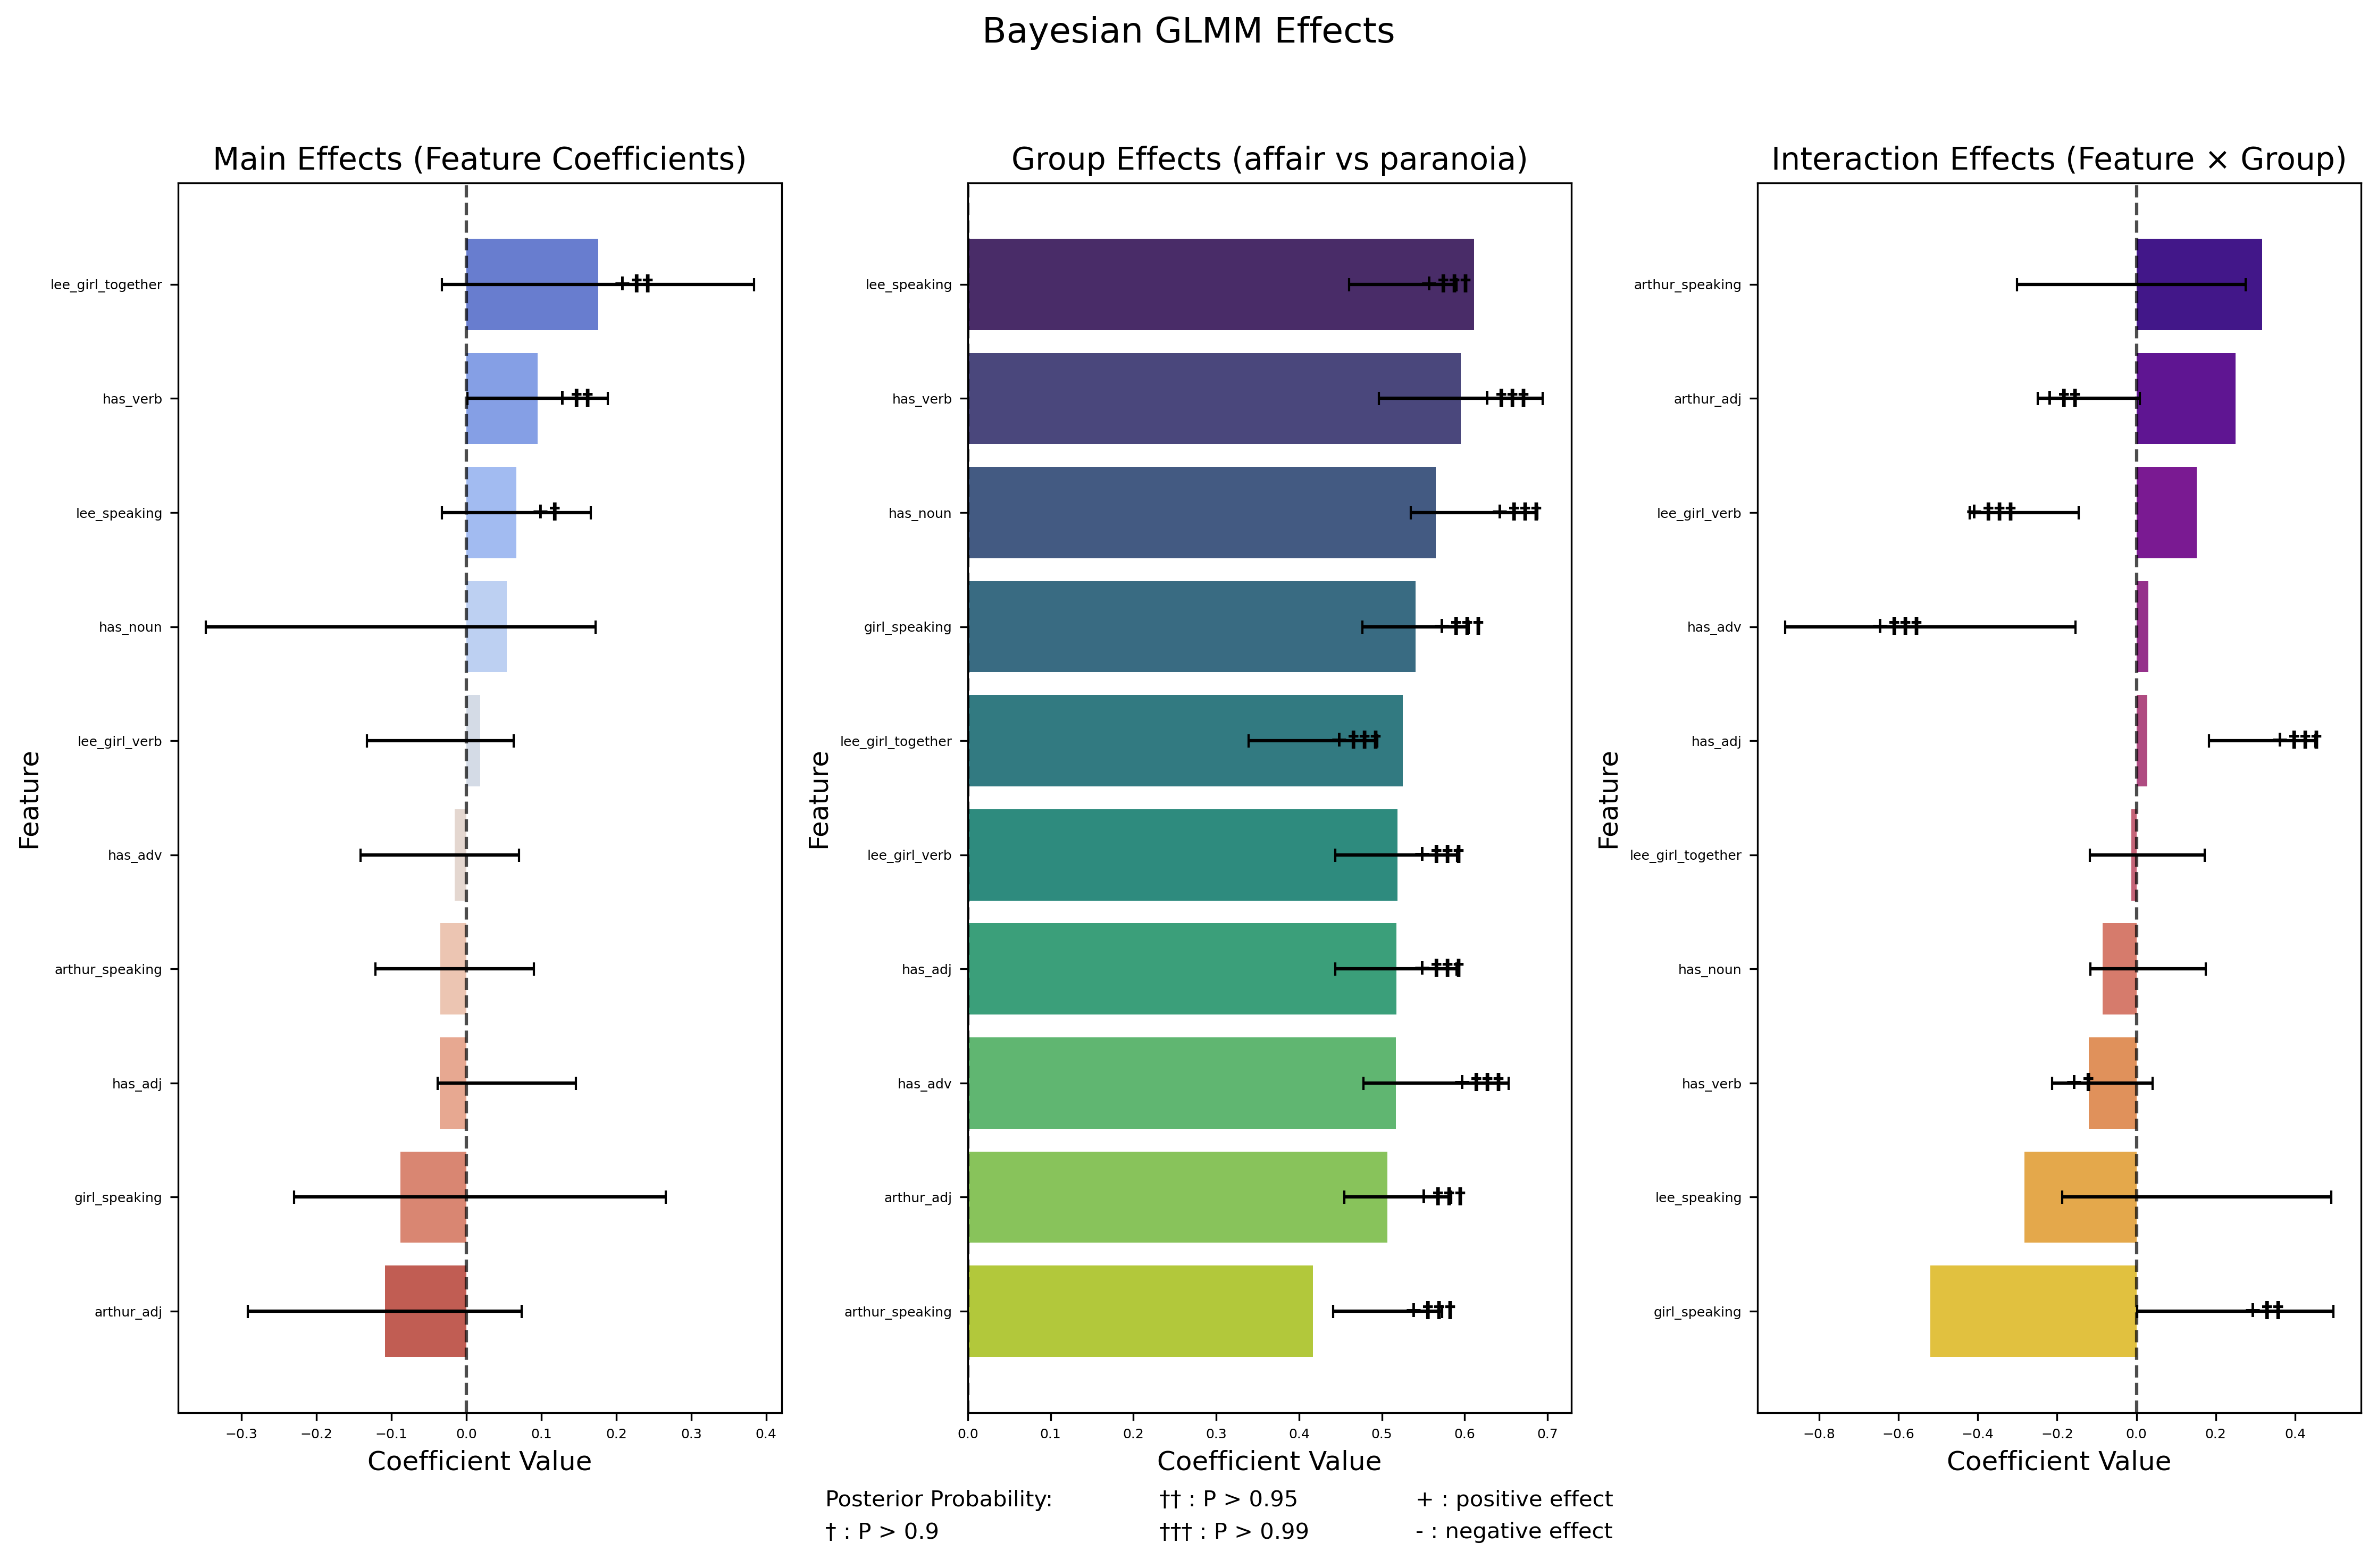

In [33]:
plot_glmm_effects(data_dict=main_analysis_a0p0)

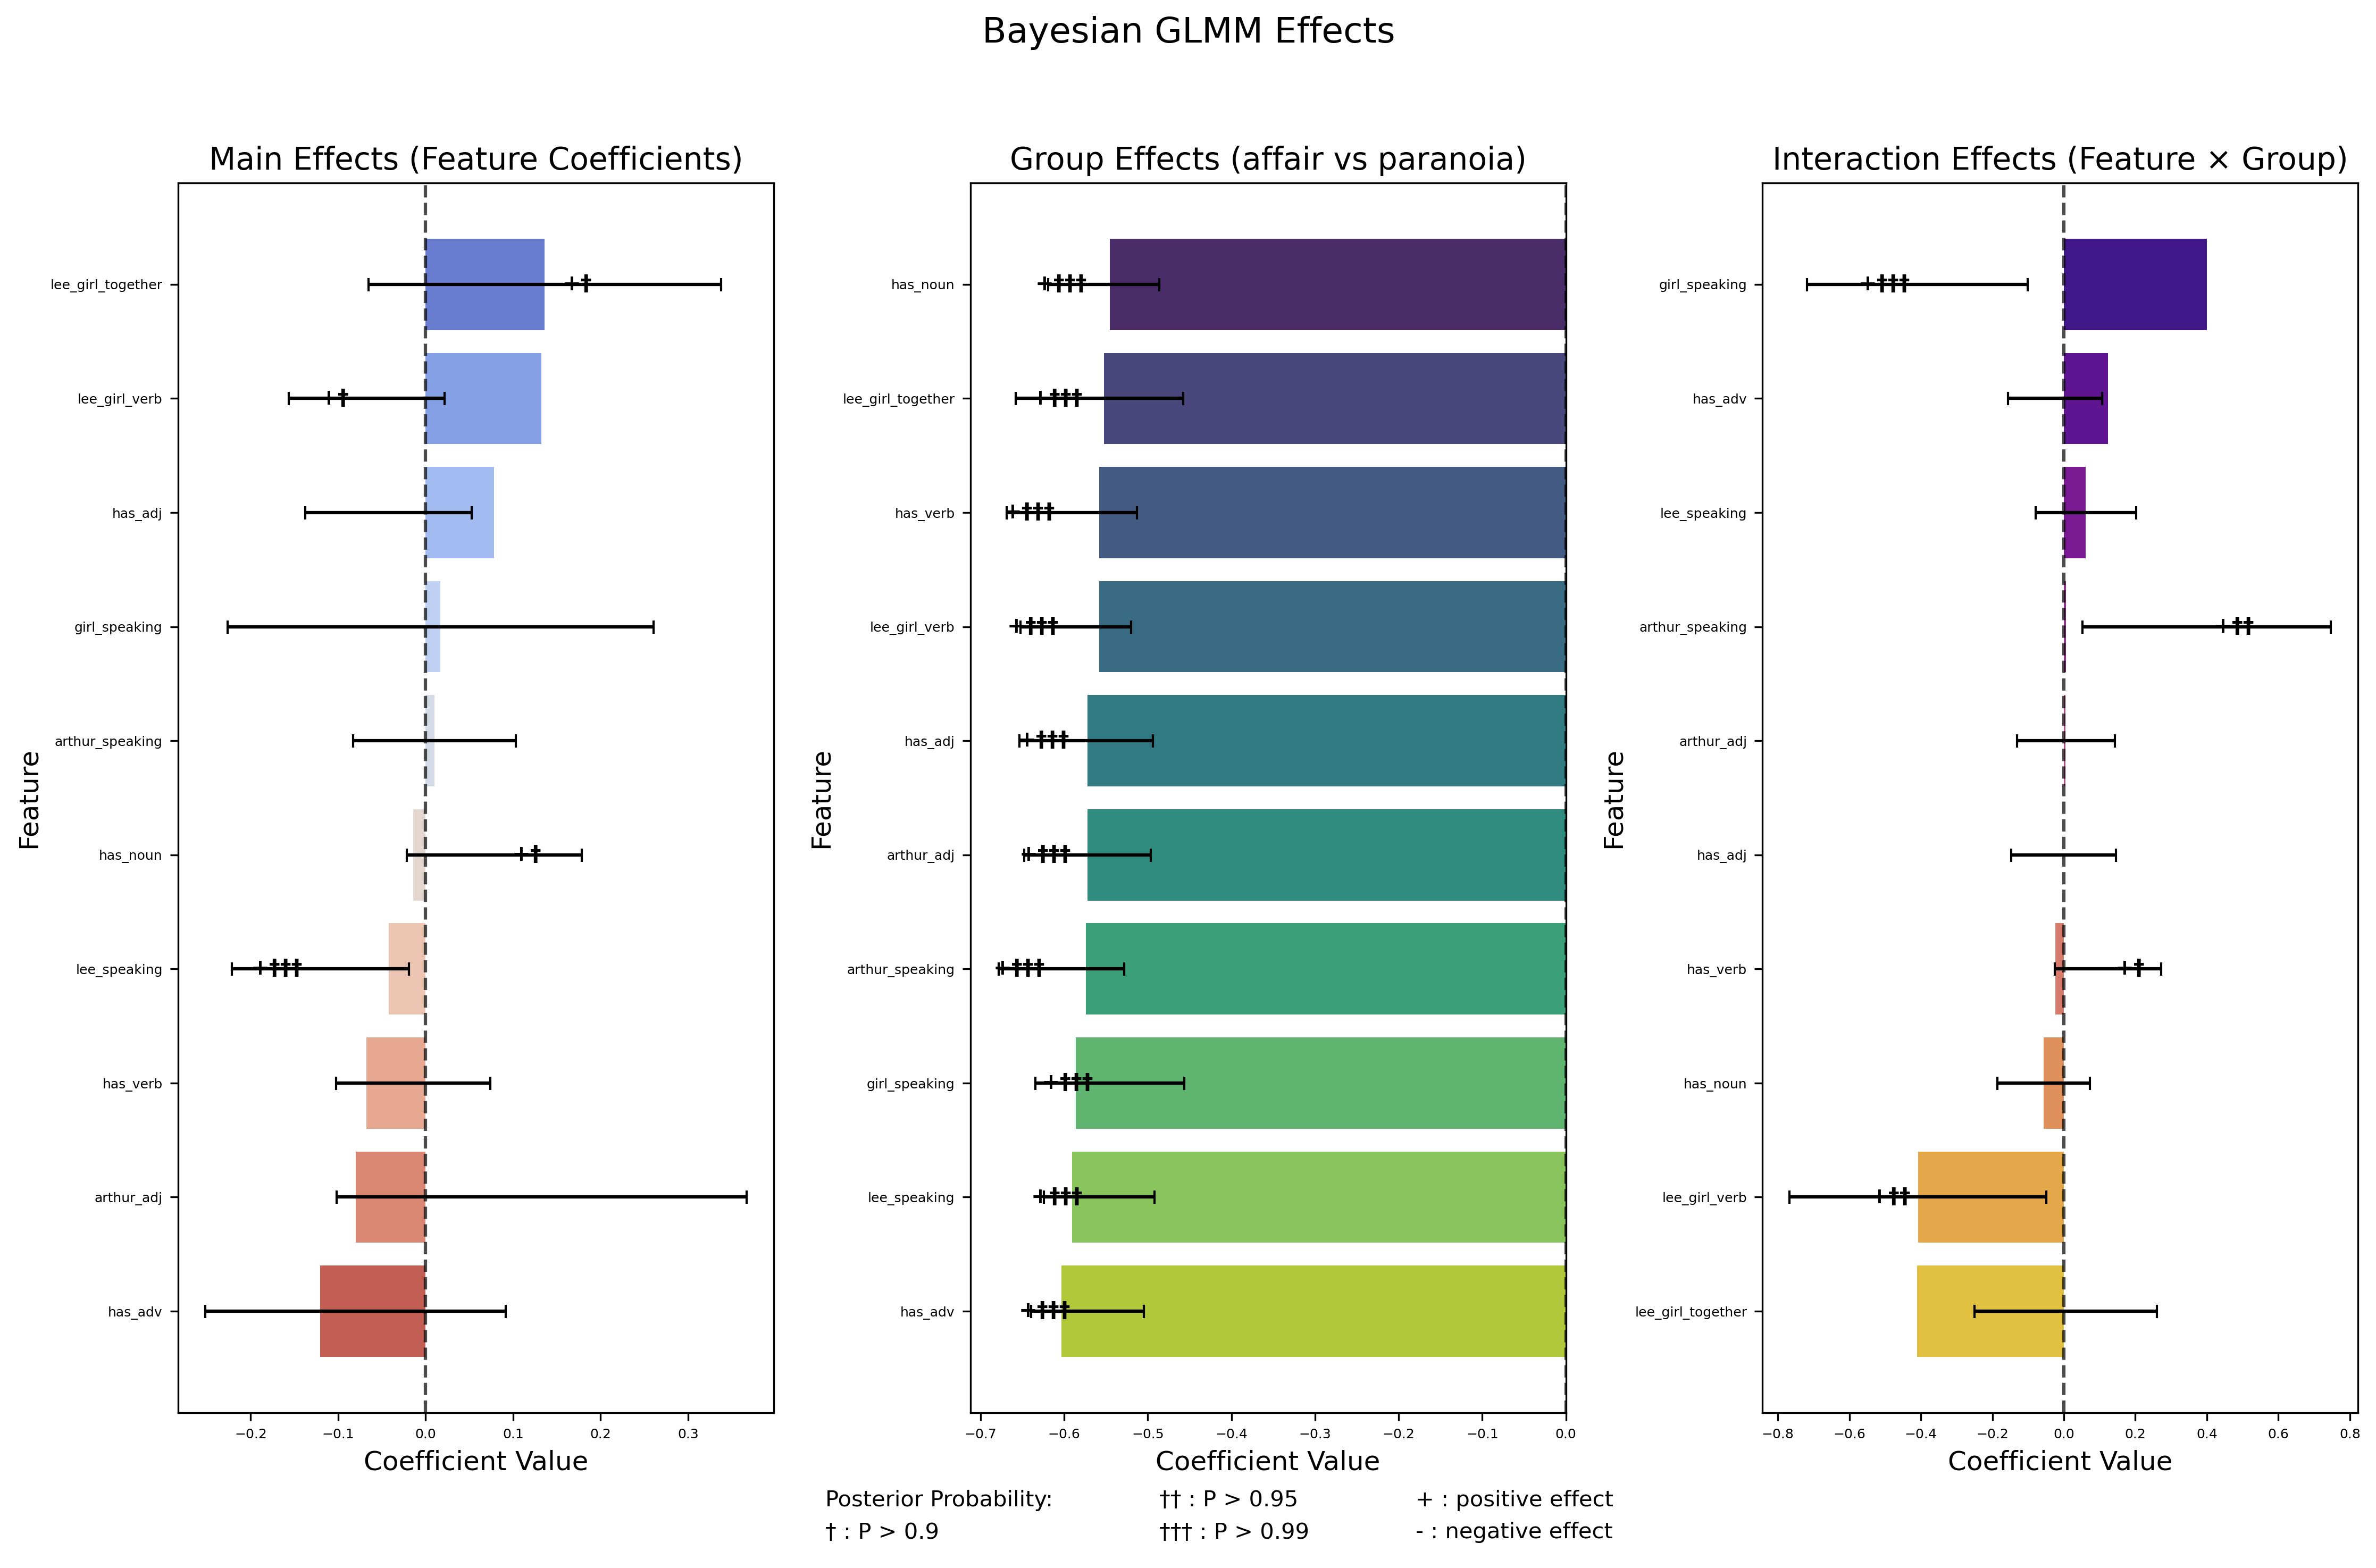

In [34]:
plot_glmm_effects(data_dict=main_analysis_a1p1)

## P3 - behavior-content analysis

In [8]:
behav_result_file = Path(OUTPUT_DIR) / '12_behavioral_analysis' / 'results.json'

In [9]:
def load_results(filename):
    """Load analysis results from JSON file"""
    with open(filename, 'r') as f:
        return json.load(f)

In [10]:
behav_results = load_results(behav_result_file)

In [13]:
def plot_behavioral_content_analysis(results, save_path=None, figsize=(1.5, 4), label=True):
    """Create figure showing content feature effects split by group
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the analysis results
    save_path : str, optional
        Path to save the figure
    figsize : tuple, optional
        Figure size (width, height)
    label : bool
        Whether to include feature labels on the y-axis
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure with behavioral content analysis
    """
    # Create figure with two subplots (rows instead of columns)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Define features to plot
    plot_features = ['has_adj', 'has_adv', 'has_noun', 'has_verb', 'arthur_speaking', 
                     'girl_speaking', 'lee_speaking', 'arthur_adj', 'lee_girl_together', 'lee_girl_verb']

    # Check if we have the new group-specific effects structure
    has_group_effects = 'group_specific_effects' in results['content_relationships']
    
    # Prepare data for Affair group
    affair_data = {
        'feature': plot_features,
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    # Prepare data for Paranoia group
    paranoia_data = {
        'feature': plot_features,
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    # Fill in data based on available structure
    for f in plot_features:
        if has_group_effects and f in results['content_relationships']['group_specific_effects']:
            # Use the new group-specific effects structure
            group_effects = results['content_relationships']['group_specific_effects'][f]['main']
            
            # Get affair group data
            affair_data['effect'].append(np.log(group_effects['affair']['odds_ratio']))
                
            affair_data['ci_lower'].append(np.log(group_effects['affair']['lower']))
            affair_data['ci_upper'].append(np.log(group_effects['affair']['upper']))
            affair_data['probability'].append(group_effects['affair']['prob_positive'])
            
            # Get paranoia group data
            paranoia_data['effect'].append(np.log(group_effects['paranoia']['odds_ratio']))
                
            paranoia_data['ci_lower'].append(np.log(group_effects['paranoia']['lower']))
            paranoia_data['ci_upper'].append(np.log(group_effects['paranoia']['upper']))
            paranoia_data['probability'].append(group_effects['paranoia']['prob_positive'])
            
        else:
            # Fall back to the old structure if needed
            try:
                # For affair group (main effects)
                affair_data['effect'].append(results['content_relationships']['coefficients'][f])
                    
                affair_data['ci_lower'].append(results['content_relationships']['confidence_intervals']['lower'][f])
                affair_data['ci_upper'].append(results['content_relationships']['confidence_intervals']['upper'][f])
                affair_data['probability'].append(1 - results['content_relationships']['prob_nonzero'][f])
                
                # For paranoia group (main + interaction effects)
                main_effect = results['content_relationships']['coefficients'][f]
                interaction_key = f'group_{f}_interaction'
                
                if interaction_key in results['content_relationships']['coefficients']:
                    interaction = results['content_relationships']['coefficients'][interaction_key]
                    total_effect = main_effect + interaction
                    
                    paranoia_data['effect'].append(total_effect)
                    
                    # Calculate combined CI
                    main_sd = results['content_relationships']['posterior_sds'][f]
                    interaction_sd = results['content_relationships']['posterior_sds'][interaction_key]
                    total_sd = np.sqrt(main_sd**2 + interaction_sd**2)
                    
                    paranoia_data['ci_lower'].append(total_effect - 1.96 * total_sd)
                    paranoia_data['ci_upper'].append(total_effect + 1.96 * total_sd)
                    
                    # Calculate probability
                    z_score = total_effect / total_sd
                    p_nonzero = 1 - 2 * (1 - stats.norm.cdf(abs(z_score)))
                    paranoia_data['probability'].append(p_nonzero)
                else:
                    # If no interaction term, use same as affair group
                    paranoia_data['effect'].append(affair_data['effect'][-1])
                    paranoia_data['ci_lower'].append(affair_data['ci_lower'][-1])
                    paranoia_data['ci_upper'].append(affair_data['ci_upper'][-1])
                    paranoia_data['probability'].append(affair_data['probability'][-1])
            except KeyError:
                # Handle missing features
                print(f"Warning: Feature '{f}' not found in results")
                # Add placeholder values
                affair_data['effect'].append(0)
                affair_data['ci_lower'].append(0)
                affair_data['ci_upper'].append(0)
                affair_data['probability'].append(0)
                
                paranoia_data['effect'].append(0)
                paranoia_data['ci_lower'].append(0)
                paranoia_data['ci_upper'].append(0)
                paranoia_data['probability'].append(0)
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # Define group colors
    affair_color = COLORS['affair']
    paranoia_color = COLORS['paranoia']
    
    # Helper function for color adjustment
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = plt.cm.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    # Function to plot one group
    def plot_group(ax, df, group_color, is_bottom=False, label=True):
        # Create color variants for probability levels
        color_high = group_color
        color_med = adjust_color_alpha(group_color, 0.7)
        color_low = adjust_color_alpha(group_color, 0.4)
        gray_color = '#777777'
        
        # Determine color based on posterior probability AND CI crossing zero
        colors = []
        for _, row in df.iterrows():
            # Check if CI crosses zero
            ci_crosses_zero = (row['ci_lower'] < 0 and row['ci_upper'] > 0)
            
            # Get the posterior probability
            prob = row['probability']
            
            # Assign color based on probability and CI
            if not ci_crosses_zero:
                if prob > 0.999:
                    colors.append(color_high)
                elif prob > 0.99:
                    colors.append(color_med)  
                elif prob > 0.95:
                    colors.append(color_low)
                else:
                    colors.append(gray_color)
            else:
                colors.append(gray_color)
        
        # Calculate x-positions (features)
        x_pos = np.arange(len(df))
        
        # Find appropriate axis limits
        all_values = list(df['effect']) + list(df['ci_lower']) + list(df['ci_upper'])
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Add padding
        padding = 0.1 * (max_val - min_val)
        y_min = min_val - padding
        y_max = max_val + padding
        
        # Ensure zero is visible if it's close to the range
        if min_val > -padding and min_val < 0:
            y_min = -padding
        if max_val < padding and max_val > 0:
            y_max = padding
            
        # Plot reference line at zero
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
        # Plot data points and intervals
        for i, (_, row) in enumerate(df.iterrows()):
            # Plot CI line - vertical now
            ax.vlines(x=x_pos[i], ymin=row['ci_lower'], ymax=row['ci_upper'], 
                     color=colors[i], alpha=0.6, linewidth=2)
            
            # Plot point
            ax.scatter(x_pos[i], row['effect'], color=colors[i], s=5, zorder=3)
        
        # Configure axis labels and ticks
        y_label = "Odds Ratio"
            
        ax.set_ylabel(y_label)

        # Only add x-axis labels on the bottom plot
        if is_bottom and label:
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f.replace('_', ' ').title() for f in df['feature']], rotation=90, ha='right')
        elif not label:
            ax.set_ylabel("")
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        # Set axis limits
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(-0.5, len(df) - 0.5)
        
        # Add grid
        ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # Calculate global min and max for consistent y-axis scaling
    all_affair_values = list(df_affair['effect']) + list(df_affair['ci_lower']) + list(df_affair['ci_upper'])
    all_paranoia_values = list(df_paranoia['effect']) + list(df_paranoia['ci_lower']) + list(df_paranoia['ci_upper'])
    all_values = all_affair_values + all_paranoia_values
    
    global_min = min(all_values)
    global_max = max(all_values)
    
    # Add padding
    padding = 0.1 * (global_max - global_min)
    global_y_min = global_min - padding
    global_y_max = global_max + padding
    
    # Ensure zero is visible if it's close to the range
    if global_min > -padding and global_min < 0:
        global_y_min = -padding
    if global_max < padding and global_max > 0:
        global_y_max = padding

    # Plot both groups
    plot_group(ax1, df_affair, 'Affair Group', affair_color, is_bottom=False, label=False)
    plot_group(ax2, df_paranoia, 'Paranoia Group', paranoia_color, is_bottom=True, label=label)
    
    # Set the same y-axis limits for both plots
    ax1.set_ylim(global_y_min, global_y_max)
    ax2.set_ylim(global_y_min, global_y_max)
    
    # Set x-axis limits
    ax1.set_xlim(-0.5, len(df_affair) - 0.5)
    ax2.set_xlim(-0.5, len(df_paranoia) - 0.5)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Adjust space between subplots
    
    # Save figure if path is provided
    if save_path:
        if label:
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_vertical_label.png', dpi=300, bbox_inches='tight')
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_vertical_label.svg', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_vertical_nolabel.png', dpi=300, bbox_inches='tight')
            plt.savefig(SAVE_DIR_FIG4 / f'{save_path}_vertical_nolabel.svg', dpi=300, bbox_inches='tight')
    
    return fig

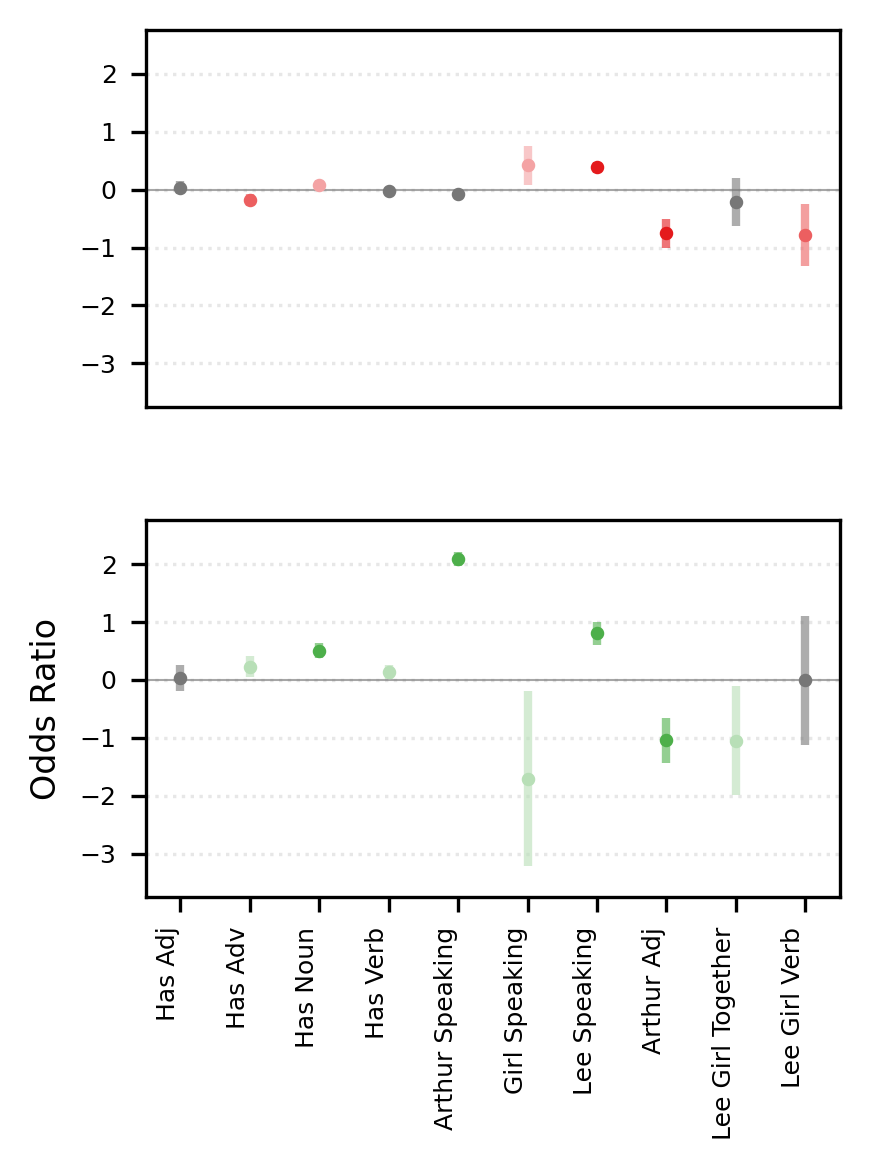

In [14]:
plot_behavioral_content_analysis(behav_results, figsize=(3, 4), label=True)

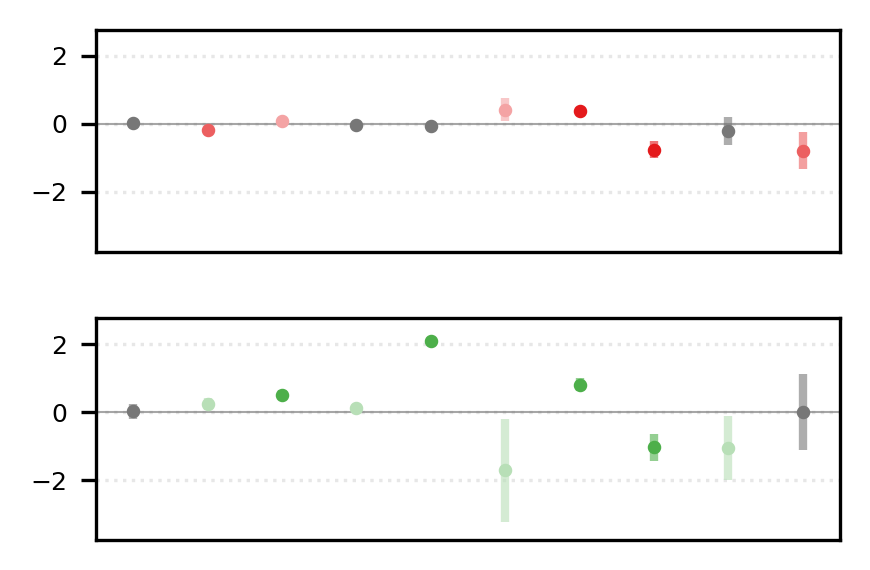

In [12]:
plot_behavioral_content_analysis(behav_results, use_cohens_d=False, save_path='behavioral_content_analysis', figsize=(3, 2), label=False)